In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer, ModeClusterer_HDBSCAN  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import get_mpe_data, DatasetGetter
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2_C02'
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = "../../data/nw2/raw/nw2d01_" + data_file_name + ".parquet"
weather_data_path = "../../data/nw2/mvbc_data.parquet"

dt_start =  datetime.datetime(2022,11,1,tzinfo=utc)
dt_stop  = datetime.datetime(2023,3,20,tzinfo=utc)
dsg = DatasetGetter(dt_start, dt_stop, location=location)
dsg.get_longterm_data()
dsg.save_data(data_path)

In [4]:
data = pd.read_parquet(data_path)
weather_data = pd.read_parquet(weather_data_path)

In [5]:
name_location = 'NW2_C02'
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(data, direction, name_location)

In [6]:
def select_max_row(data, selection_column):
    """
    Selects the row with the highest value of a specific column when the index is duplicated in a dataframe.
    :param data: The dataframe to select rows from.
    :param selection_column: The name of the column to select the maximum of.
    :return: A dataframe with the selected rows.
    """
    max_rows = data.groupby(data.index).apply(lambda x: x.loc[x[selection_column].idxmax()])
    return max_rows

In [7]:
mc = {}
clustering_data = {}
clustered_modes = {}
modes = {}

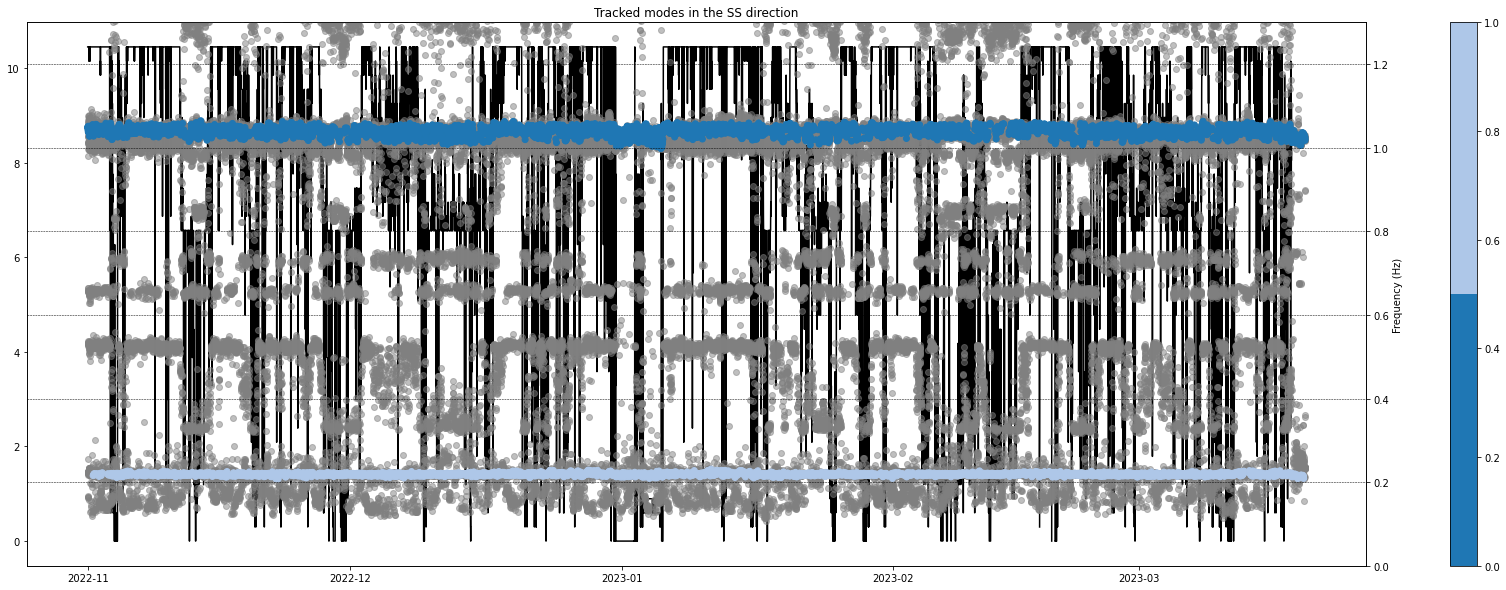

In [8]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 10, "damping": 10},
    index_divider = 1000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
ax2.plot(data.filter(like='rpm').index, data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)



plt.show()

In [9]:
direction = 'SS'
label_mode1 = 1
label_mode2 = 0

modes[direction + '1'] = clustered_modes[direction][clustered_modes[direction].labels == label_mode1]
modes[direction + '1'] = \
    modes[direction + '1'][~modes[direction + '1'].index.duplicated()]\
        .reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

modes[direction + '2'] = clustered_modes[direction][clustered_modes[direction].labels == label_mode2]
modes[direction + '2'] = \
    modes[direction + '2'][~modes[direction + '2'].index.duplicated()]\
        .reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

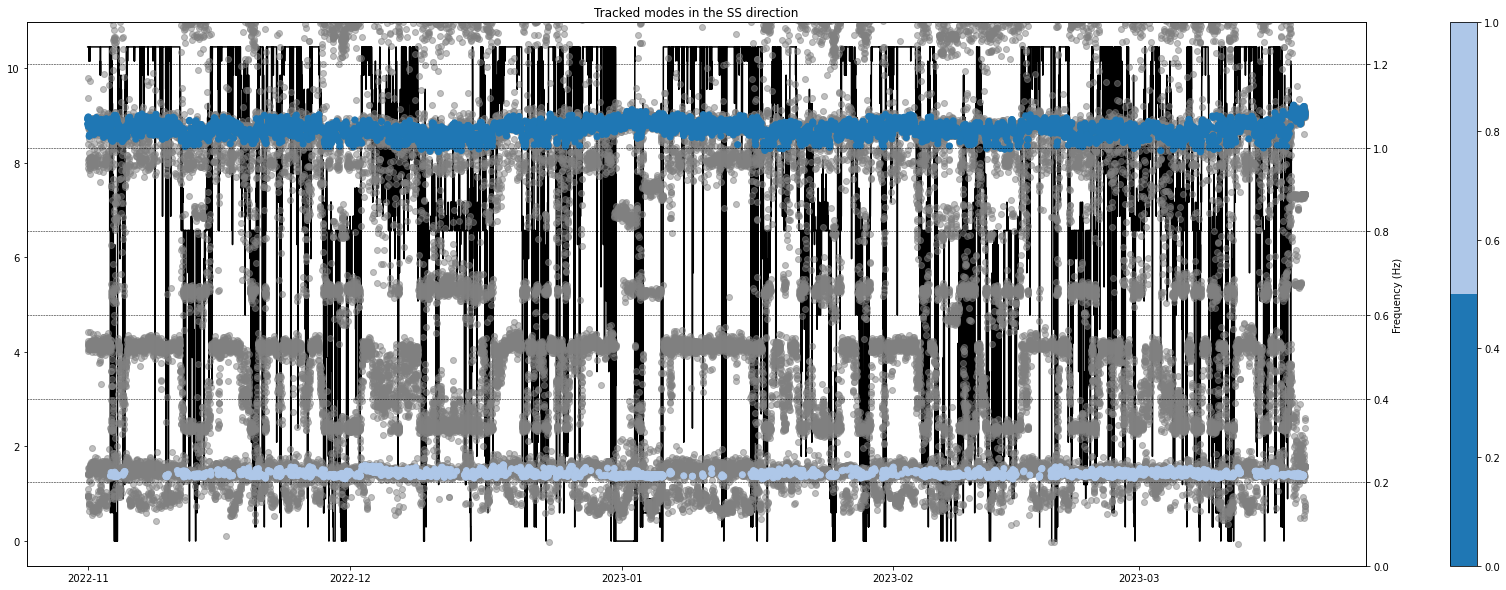

In [10]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 4, "damping": 2},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
ax2.plot(data.filter(like='rpm').index, data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)



plt.show()

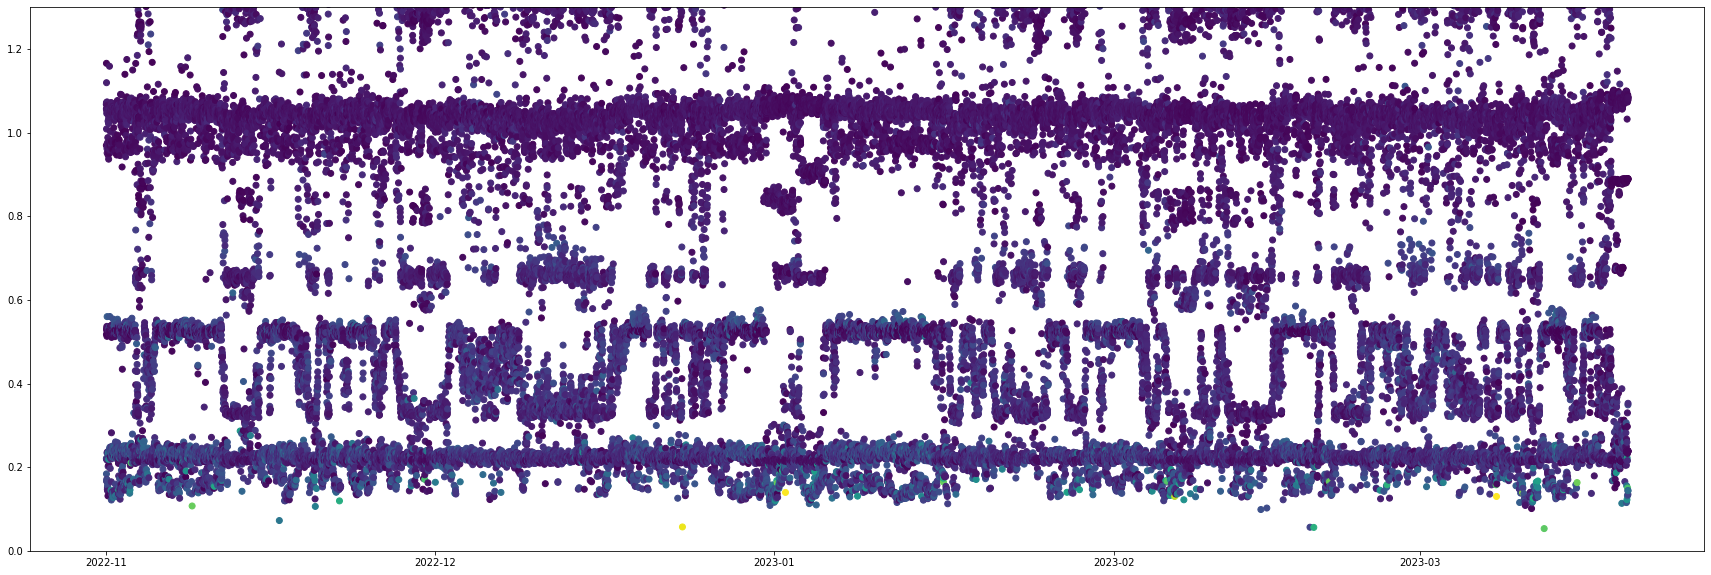

In [11]:
plt.figure(figsize=(30,10))
plt.scatter(clustering_data[direction].index, clustering_data[direction].frequency, c=clustering_data[direction]['damping'], alpha=1, cmap='viridis')
plt.ylim(0, 1.3)
plt.show()

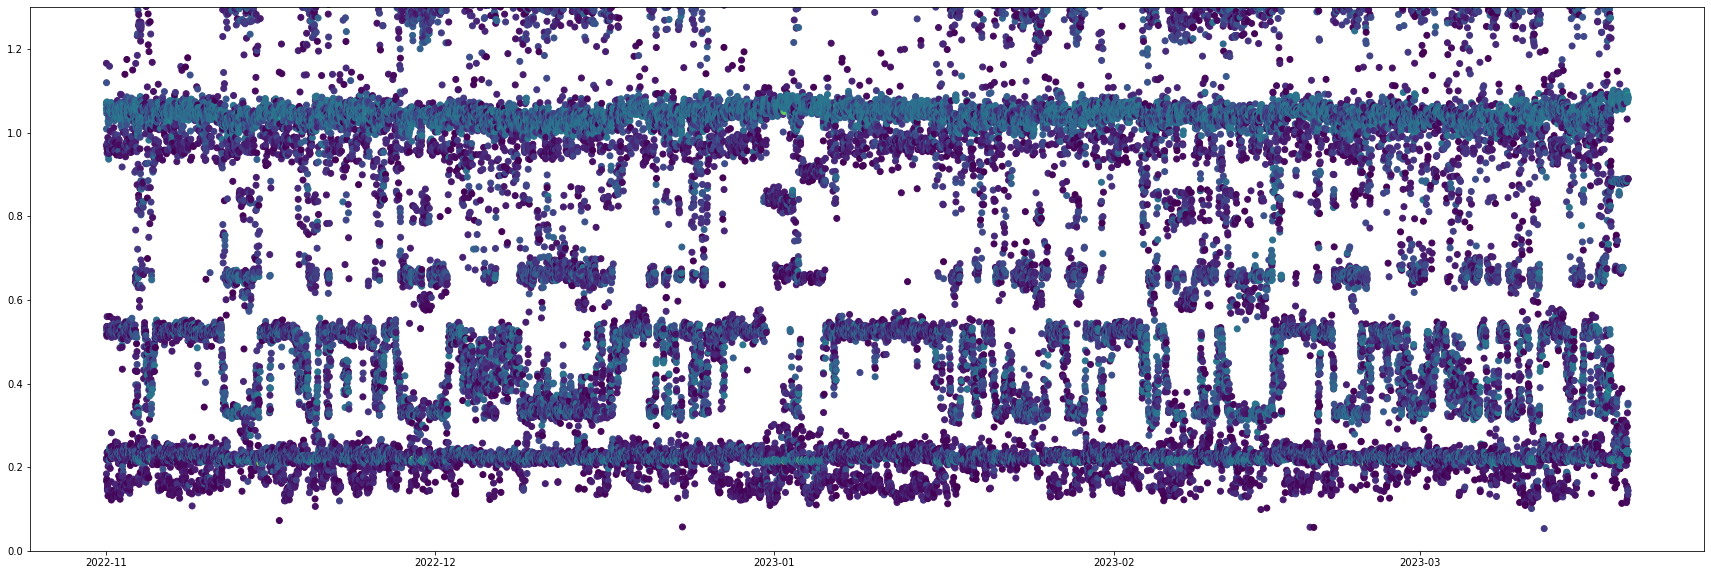

In [12]:
plt.figure(figsize=(30,10))
plt.scatter(clustering_data[direction].index, clustering_data[direction].frequency, c=clustering_data[direction]['size'], alpha=1, cmap='viridis')
plt.ylim(0, 1.3)
plt.show()

In [13]:
direction = 'FA'
label_mode1 = 1
label_mode2 = 0

modes[direction + '1'] = clustered_modes[direction][clustered_modes[direction].labels == label_mode1]
modes[direction + '1'] = \
    modes[direction + '1'][~modes[direction + '1'].index.duplicated()]\
        .reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

modes[direction + '2'] = clustered_modes[direction][clustered_modes[direction].labels == label_mode2]
modes[direction + '2'] = \
    modes[direction + '2'][~modes[direction + '2'].index.duplicated()]\
        .reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

# Harmonics

In [14]:
positive_rpm = data.filter(like='rpm').loc[data.filter(like='rpm').values > 0]
harmonic_1p = 1/60 * positive_rpm
harmonic_3p = 3/60 * positive_rpm
harmonic_3p2 = 2 * harmonic_3p
harmonic_3p3 = 3 * harmonic_3p
harmonic_3p4 = 4 * harmonic_3p
harmonic_3p5 = 5 * harmonic_3p

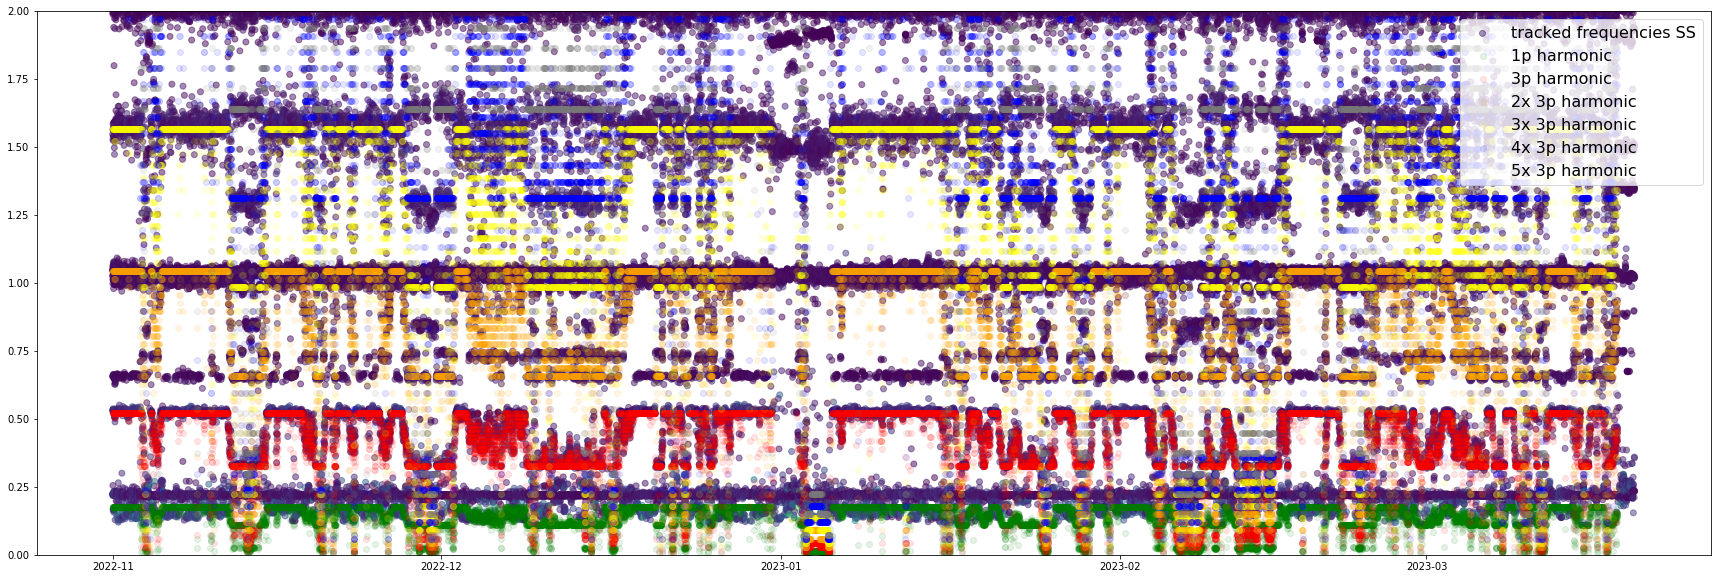

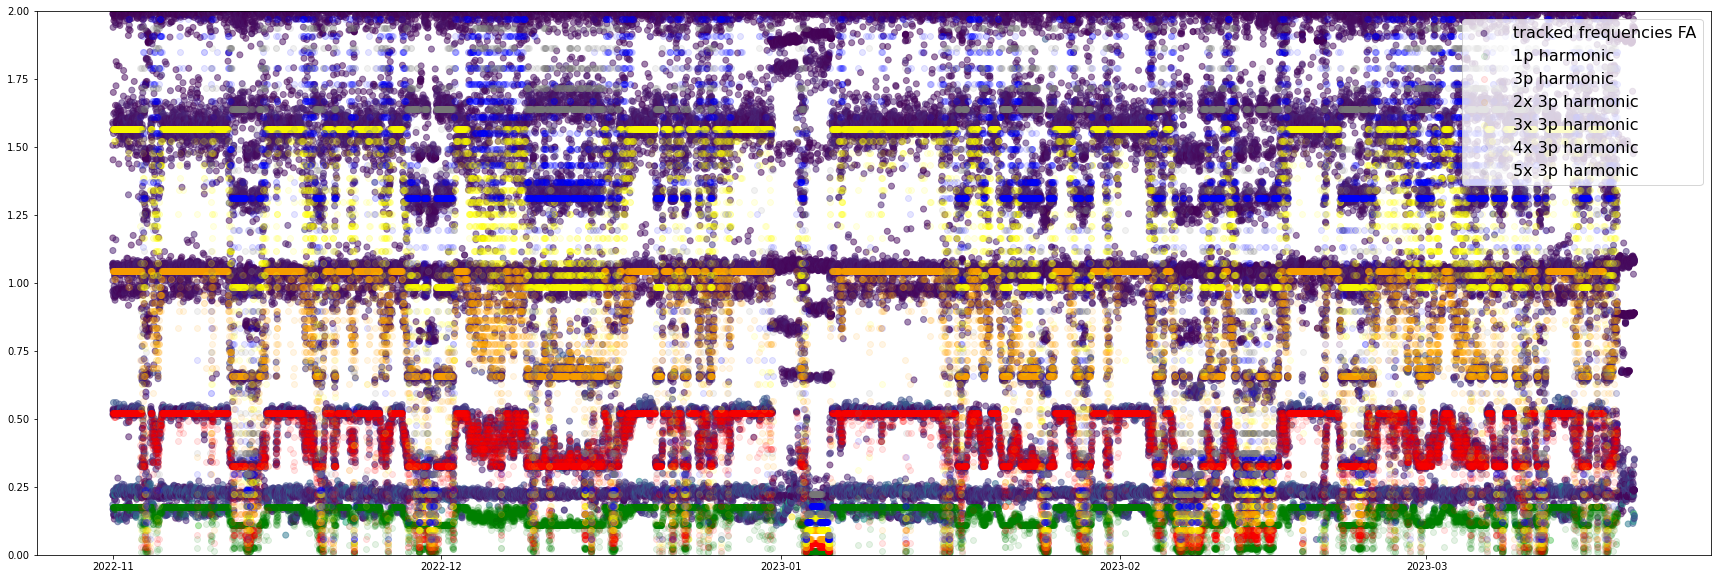

In [15]:
for direction in ['SS', 'FA']:
    plt.figure(figsize = (30,10))
    plt.scatter(clustering_data[direction].index, clustering_data[direction].frequency, c=clustering_data[direction]['damping'], alpha=0.5, cmap='viridis', label = 'tracked frequencies ' + direction)
    
    plt.scatter(harmonic_1p.filter(like='rpm').index, harmonic_1p.filter(like='rpm').values, color='green', alpha=0.1, label='1p harmonic')
    plt.scatter(harmonic_3p.filter(like='rpm').index, harmonic_3p.filter(like='rpm').values, color='r', alpha=0.1, label='3p harmonic')
    plt.scatter(harmonic_3p2.filter(like='rpm').index, harmonic_3p2.filter(like='rpm').values, color='orange', alpha=0.1, label='2x 3p harmonic')
    plt.scatter(harmonic_3p3.filter(like='rpm').index, harmonic_3p3.filter(like='rpm').values, color='yellow', alpha=0.1, label='3x 3p harmonic')
    plt.scatter(harmonic_3p4.filter(like='rpm').index, harmonic_3p4.filter(like='rpm').values, color='blue', alpha=0.1, label='4x 3p harmonic')
    plt.scatter(harmonic_3p5.filter(like='rpm').index, harmonic_3p5.filter(like='rpm').values, color='grey', alpha=0.1, label='5x 3p harmonic')


    plt.ylim(0, 2)
    plt.legend(loc='upper right', fontsize=16)
    plt.show()

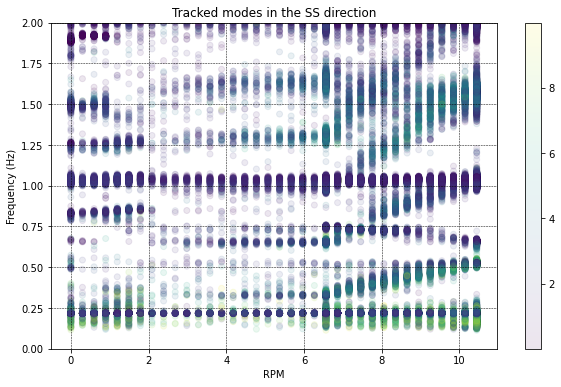

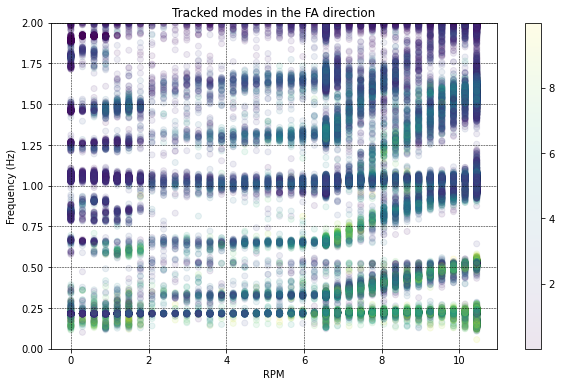

In [16]:
for direction in ['SS', 'FA']:
    plt.figure(figsize = (10,6))
    plt_data = clustering_data[direction][clustering_data[direction].damping < 10]
    plt_rpm = data.filter(like='rpm').loc[plt_data.index]
    plt_data = pd.concat([plt_data, plt_rpm], axis=1)
    plt.scatter(plt_data.filter(regex='rpm'), plt_data['frequency'], alpha=0.1, c=plt_data['damping'], cmap = 'viridis')
    plt.grid(True, color='k', linestyle='--', linewidth=0.5)
    cbar = plt.colorbar()
    plt.xlabel('RPM')
    plt.ylabel('Frequency (Hz)')
    plt.title('Tracked modes in the ' + direction + ' direction')
    plt.ylim(0, 2)
    plt.show()


<Figure size 720x432 with 0 Axes>

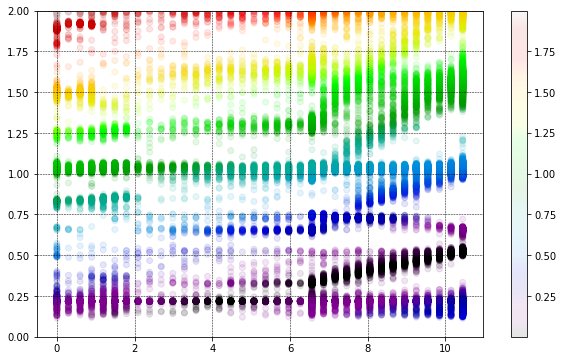

<Figure size 720x432 with 0 Axes>

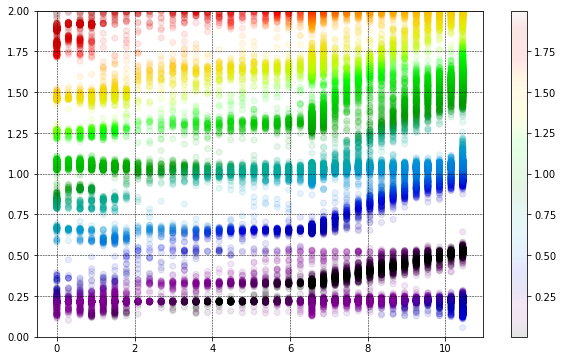

In [63]:
linear_trend_data = {}
distances = {}
p = 3
for direction in ['SS', 'FA']:
    plt.figure(figsize = (10,6))
    plt_data = clustering_data[direction][clustering_data[direction].damping < 10]
    plt_rpm = data.filter(like='rpm').loc[plt_data.index]
    plt_data = pd.concat([plt_data, plt_rpm], axis=1)[plt_data.frequency < 2]
    linear_trend_data[direction] = plt_data.filter(regex='|'.join(['frequency', 'rpm'])).drop(['std_frequency'], axis=1).dropna()
    distances[direction] = np.abs((p/60 * linear_trend_data[direction].filter(regex='rpm').values[:,0]) - linear_trend_data[direction]['frequency'].values)
    plt.figure(figsize = (10,6))
    plt.scatter(linear_trend_data[direction].filter(regex='rpm'), linear_trend_data[direction]['frequency'], alpha=0.1, c=distances[direction], cmap = 'nipy_spectral')
    plt.grid(True, color='k', linestyle='--', linewidth=0.5)
    cbar = plt.colorbar(alpha=1)
    plt.ylim(0, 2)

<Figure size 720x432 with 0 Axes>

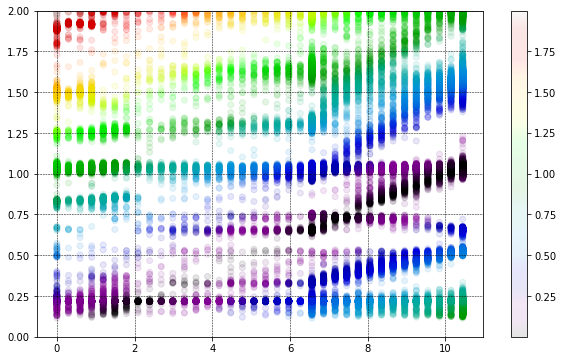

<Figure size 720x432 with 0 Axes>

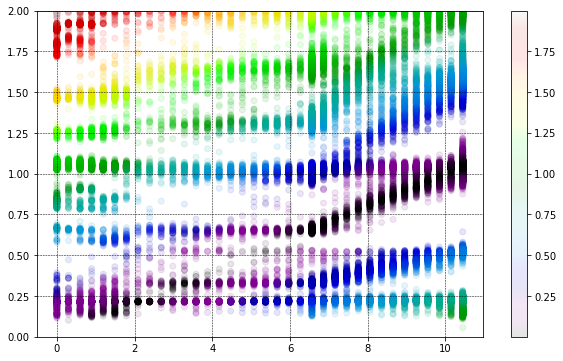

In [62]:
linear_trend_data = {}
distances = {}
p = 6
for direction in ['SS', 'FA']:
    plt.figure(figsize = (10,6))
    plt_data = clustering_data[direction][clustering_data[direction].damping < 10]
    plt_rpm = data.filter(like='rpm').loc[plt_data.index]
    plt_data = pd.concat([plt_data, plt_rpm], axis=1)[plt_data.frequency < 2]
    linear_trend_data[direction] = plt_data.filter(regex='|'.join(['frequency', 'rpm'])).drop(['std_frequency'], axis=1).dropna()
    distances[direction] = np.abs((p/60 * linear_trend_data[direction].filter(regex='rpm').values[:,0]) - linear_trend_data[direction]['frequency'].values)
    plt.figure(figsize = (10,6))
    plt.scatter(linear_trend_data[direction].filter(regex='rpm'), linear_trend_data[direction]['frequency'], alpha=0.1, c=distances[direction], cmap = 'nipy_spectral')
    plt.grid(True, color='k', linestyle='--', linewidth=0.5)
    cbar = plt.colorbar()
    plt.ylim(0, 2)

In [21]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

dbscan = {}
clusters = {}
linear_trend_data = {}
for direction in ['SS', 'FA']:
    plt.figure(figsize = (10,6))
    plt_data = clustering_data[direction][clustering_data[direction].damping < 10]
    plt_rpm = data.filter(like='rpm').loc[plt_data.index]
    plt_data = pd.concat([plt_data, plt_rpm], axis=1)
    
    linear_trend_data[direction] = plt_data.filter(regex='|'.join(['frequency', 'rpm'])).drop(['std_frequency'], axis=1).dropna()
    # Step 2: Compute the covariance matrix and its inverse
    X = linear_trend_data[direction]

    dbscan[direction] = DBSCAN(eps=0.1, min_samples=10)
    clusters[direction] = dbscan[direction].fit_predict(X)


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

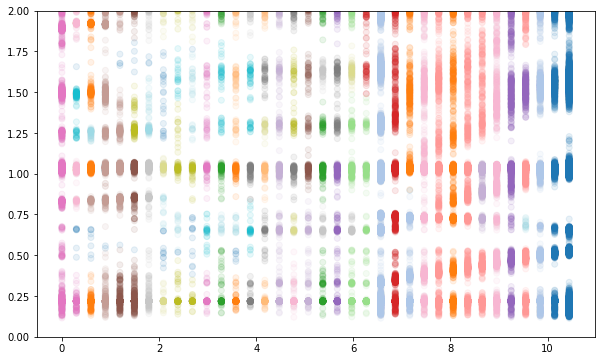

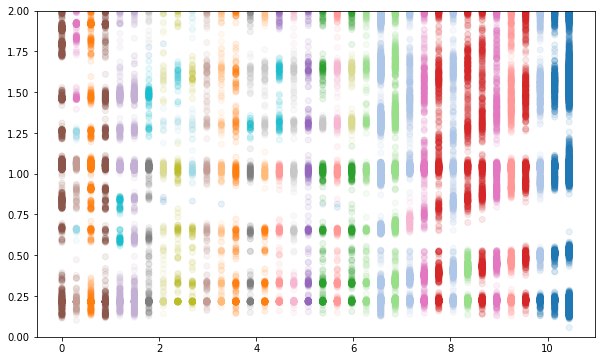

In [22]:
for direction in ['SS', 'FA']:
    linear_trend_data[direction]['clusters'] = clusters[direction]
    plt.figure(figsize = (10,6))
    plt.scatter(linear_trend_data[direction].filter(regex='rpm'), linear_trend_data[direction]['frequency'], alpha=0.1, c=linear_trend_data[direction]['clusters'], cmap = 'tab20')
    plt.ylim(0, 2)

In [112]:



def dbscan_linear_trend(X, a_min, a_max, eps=0.1, min_samples=5):
    """Identify linear trended clusters in a 2D dataset using DBSCAN.

    This function takes a 2D dataset and applies DBSCAN clustering to identify clusters
    with a linear trend along the x-axis (i.e., a slope within a specified range).
    The function returns a list of Boolean masks that indicate which points belong to each
    linear trended cluster.

    Args:
        X (ndarray): A 2D array of shape (n_samples, 2) containing the dataset.
        a_min (float): The minimum slope of a linear trend that will be considered a cluster.
        a_max (float): The maximum slope of a linear trend that will be considered a cluster.
        eps (float, optional): The maximum distance between two points in the same cluster.
            Points that are farther apart than this distance are considered to be in different
            clusters. Defaults to 0.1.
        min_samples (int, optional): The minimum number of points required to form a dense region.
            Points that are not part of a dense region are considered to be noise. Defaults to 5.

    Returns:
        list: A list of Boolean masks of length n_clusters, where each mask indicates which
        points belong to the corresponding linear trended cluster.

    """
    # Step 1: Fit a linear regression to the dataset
    reg = LinearRegression().fit(X[:, 0].reshape(-1, 1), X[:, 1])
    a = reg.coef_[0]

    # Step 2: Use DBSCAN to identify clusters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)

    # Step 3: Identify the linear trended clusters
    '''linear_trended_clusters = []
    for i in range(np.max(clusters) + 1):
        mask = clusters == i
        X_cluster = X[mask]
        if len(X_cluster) >= min_samples:
            reg = LinearRegression().fit(X_cluster[:, 0].reshape(-1, 1), X_cluster[:, 1])
            a = reg.coef_[0]
            if a_min <= a <= a_max:
                linear_trended_clusters.append(mask)
    '''
    # Step 4: Visualize the results
    return clusters

KeyError: 'mask'

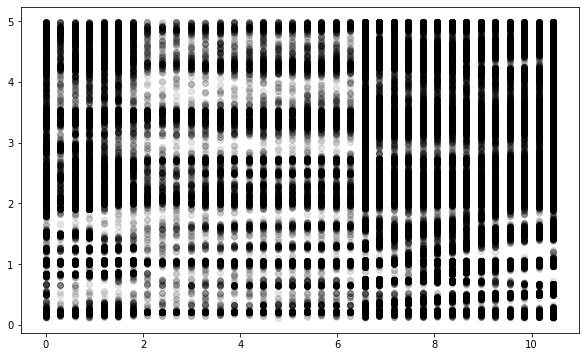

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(linear_trend_data['SS'].filter(regex='rpm'), linear_trend_data['SS'].frequency, alpha=0.1, c='k')
masked_data = linear_trend_data['SS'][linear_trend_data['SS']['mask'] == True]
plt.scatter(masked_data.filter(regex='rpm'), masked_data.frequency, alpha=0.1, c='r')
plt.show()

In [136]:
masked_data

NameError: name 'masked_data' is not defined

In [110]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from sklearn.linear_model import LinearRegression

def spectral_clustering_linear_trend(X, n_clusters, a_min, a_max, sigma=1.0, k=10):
    # Step 1: Construct the similarity graph
    W = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
    W = np.exp(-euclidean_distances(X, squared=True) / (2 * sigma**2))
    W = np.maximum(W, W.T)  # Make the graph undirected

    # Step 2: Compute the graph Laplacian
    D = np.diag(W.sum(axis=1))
    L = D - W

    # Step 3: Compute the eigenvectors
    _, U = spectral_embedding(L, n_components=n_clusters, norm_laplacian=True, drop_first=False)

    # Step 4: Apply k-means to the new feature space
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(U)

    # Step 5: Identify the linear trended clusters
    linear_trended_clusters = []
    for i in range(n_clusters):
        mask = kmeans.labels_ == i
        X_cluster = X[mask]
        y_cluster = X_cluster[:, 1]
        X_cluster = X_cluster[:, 0].reshape(-1, 1)
        reg = LinearRegression().fit(X_cluster, y_cluster)
        a = reg.coef_[0]
        if a_min <= a <= a_max:
            linear_trended_clusters.append(mask)

    # Step 6: Visualize the results
    return linear_trended_clusters


In [ ]:
spectral_clustering_linear_trend()